**Busniness Understanding**

Online E-commerce websites like Amazon, Filpkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real time. This type of filtering matches each of the user's purchased and rated items to similar items, then combines those similar items into a recommendation list for the user. In this project we are going to build recommendation model for the electronics products of Amazon.

Attribute Information:

● userId : Every user identified with a unique id (First Column)

● productId : Every product identified with a unique id(Second Column)

● Rating : Rating of the corresponding product by the corresponding user(Third Column)

● timestamp : Time of the rating ( Fourth Column)

Data Source from [Kaggle ](https://www.kaggle.com/datasets/saurav9786/amazon-product-reviews)

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
upload = files.upload()

Saving Dataset_new.csv to Dataset_new (1).csv


In [2]:
df = pd.read_csv('ratings_Electronics.csv',
                             names=['userId', 'productId','rating','timestamp'], index_col=None, header=0)
df.head()

,userId,productId,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [3]:
df.shape

(7824481, 4)

In [4]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
product_ids = df["productId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(product_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(product_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["product"] = df["productId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_product = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Product: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_product, min_rating, max_rating
    )
)

Number of users: 4201696, Number of Product: 476001, Min rating: 1.0, Max rating: 5.0


In [5]:
#Check for missing values
print('Number of missing values:')
pd.DataFrame(df.isnull().sum().reset_index()).rename( columns={0:"Total missing","index":"Columns"}) 

Number of missing values:


,Columns,Total missing
0,userId,0
1,productId,0
2,rating,0
3,timestamp,0
4,user,0
5,product,0


In [6]:
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
y

array([1.  , 0.  , 0.5 , ..., 0.75, 0.75, 1.  ])

In [7]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "product"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 80% of the data and validating on 20%.
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [8]:
x

array([[ 856428,   68353],
       [  59019,  146909],
       [3068241,  319641],
       ...,
       [3595484,  356296],
       [3835941,  392236],
       [2386942,  355743]])

In [9]:
EMBEDDING_SIZE = 40


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_game, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_game = num_game
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_game,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_game, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_product, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=4000,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:439: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 168067840 elements. This may consume a large amount of memory.
  num_elements)


1565/1565 [==============================] - 3248s 2s/step - loss: 0.6118 - val_loss: 0.6203
Epoch 2/5
1565/1565 [==============================] - 3225s 2s/step - loss: 0.8440 - val_loss: 0.9670
Epoch 3/5
1565/1565 [==============================] - 3221s 2s/step - loss: 3.6761 - val_loss: 1.0959
Epoch 4/5
1565/1565 [==============================] - 3234s 2s/step - loss: 2.3421 - val_loss: 1.3800
Epoch 5/5
1565/1565 [==============================] - 3239s 2s/step - loss: 15.2902 - val_loss: 6.1086


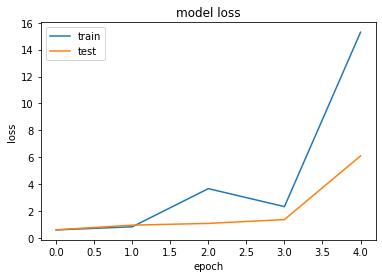

In [15]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [16]:
product_df=pd.DataFrame(df["productId"].unique().tolist(),columns=['product'])
product_df

,product
0,B000M9ISQ2
1,B002L6HE9G
2,B007MXGG5Q
3,B008HOEDYU
4,B0069R7TAM
...,...
475996,B004W4DG24
475997,B00DKR17VQ
475998,B004DR3SV4
475999,B00CO70ACU


In [18]:

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
product_purchase_by_user = df[df.userId == user_id]
movies_not_watched = product_df[
    ~product_df["product"].isin(product_purchase_by_user.productId.values)
]["product"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("DVD Game with high ratings from user")
print("----" * 8)
top_movies_user = (
    product_purchase_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .productId.values
)
movie_df_rows = product_df[product_df["product"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.product)

print("----" * 8)
print("Top 10 Amazon product recommendations")
print("----" * 8)
recommended_games = product_df[product_df["product"].isin(recommended_movie_ids)]
for row in recommended_games.itertuples():
    print(row.product)

Showing recommendations for user: A3C8UT6JXT73K8
DVD Game with high ratings from user
--------------------------------
B007MXGG5Q
B003XN24GY
B005S0BYQ6
B005PCDSBQ
B00FDXLSL4
--------------------------------
Top 10 Amazon product recommendations
--------------------------------
B0002L5R78
B003LR7ME6
B000LRMS66
B007R5YDYA
B00316263Y
B002V88HFE
B0052SCU8U
B003ES5ZUU
B0019EHU8G
B00E3W15P0
